# 出处
##### https://bravey.github.io/2019-12-20-LSTM%E4%B8%8EProphet%E6%97%B6%E9%97%B4%E5%BA%8F%E5%88%97%E9%A2%84%E6%B5%8B%E5%AE%9E%E9%AA%8C.html

### 加载、读取

In [43]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
from torch import nn

In [44]:
# 设置路径
input_path = 'C:\\Users\\iii\\Desktop\\LSTM+AQI\\数据和测算结果\\'
output_path = 'C:\\Users\\iii\\Desktop\\LSTM+AQI\\数据和测算结果\\'

In [45]:
# 读取数据
data = pd.read_excel(input_path+'aqi_eemd_out.xlsx', index_col='日期')

### 先以IMF1为例

In [46]:
data = data.IMF1
data.head(2)

日期
2014-01-01   -29.022702
2014-01-02    36.411221
Name: IMF1, dtype: float64

In [47]:
#数据预处理
data = data.dropna() #丢弃空值
dataset = data.values
dataset = dataset.astype('float32')

In [48]:
# 归一华：最大最小值法
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x/scalar, dataset)) #将数据归一化到0~1之间

### 划分数据集

In [49]:
#通过前面几条的数据来预测下一条的数据，look_back设置具体的把前面几条的数据作为预测的输入data_X，而输出就是下一条data_Y
# 每个的滑动窗口设置为2
# 即用第一天、第二天数据为X，预测第三天数据Y
def create_dataset(dataset,look_back=2): # 每个的滑动窗口设置为2
    dataX, dataY=[], []
    for i in range(len(dataset)-look_back):
        a=dataset[i:(i+look_back)]
        dataX.append(a)    # 记录窗口的值
        dataY.append(dataset[i+look_back]) # 记录除了前面两个以外的所有值作为正确的标签
    return np.array(dataX), np.array(dataY)
#创建好输入与输出 data_Y作为正确的预测值
data_X, data_Y = create_dataset(dataset)

In [50]:
#划分训练集和测试集，70%作为训练集

train_size = int(len(data_X) * 0.7)
test_size = len(data_X)-train_size

train_X = data_X[:train_size]
train_Y = data_Y[:train_size]

test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

### 改变数据格式

In [51]:
#最后，我们需要将数据改变一下形状，因为 RNN 读入的数据维度是 (seq, batch, feature)，
#所以要重新改变一下数据的维度，这里只有一个序列，所以 batch 是 1，
#而输入的 feature 就是我们希望依据的几天，这里我们定的是两个天，所以 feature 就是 2.

train_X = train_X.reshape(-1,1,2)
train_Y = train_Y.reshape(-1,1,1)
test_X = test_X.reshape(-1,1,2)

# 转化成torch 的张量
train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)

### 构建LSTM

In [52]:
#lstm 网络
class lstm_reg(nn.Module):#括号中的是python的类继承语法，父类是nn.Module类 不是参数的意思
    def __init__(self,input_size,hidden_size, output_size=1,num_layers=2): # 构造函数
        #inpu_size 是输入的样本的特征维度， hidden_size 是LSTM层的神经元个数，
        #output_size是输出的特征维度
        super(lstm_reg,self).__init__()# super用于多层继承使用，必须要有的操作
 
        self.rnn = nn.LSTM(input_size,hidden_size,num_layers)# 两层LSTM网络，
        self.reg = nn.Linear(hidden_size,output_size)#把上一层总共hidden_size个的神经元的输出向量作为输入向量，然后回归到output_size维度的输出向量中
 
    def forward(self,x): #x是输入的数据
        x, _ = self.rnn(x)# 单个下划线表示不在意的变量，这里是LSTM网络输出的两个隐藏层状态
        s,b,h = x.shape
        x = x.view(s*b, h)
        x = self.reg(x)
        x = x.view(s,b,-1)#使用-1表示第三个维度自动根据原来的shape 和已经定了的s,b来确定
        return x
#我使用了GPU加速，如果不用的话需要把.cuda()给注释掉    
net = lstm_reg(2,4)
# net = net.cuda()
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(net.parameters(),lr=1e-2)    

### 迭代训练

In [53]:
for e in range(10000):
#将tensor放在GPU上面进行运算
#不用则注释掉
    var_x = train_x#.cuda()
    var_y = train_y#.cuda()
 
    out = net(var_x)
    loss = criterion(out, var_y)
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 每1000次输出下迭代结果
    if (e+1)%1000 == 0:
        print('Epoch: {}, Loss:{:.5f}'.format(e+1, loss.item()))
#存储训练好的模型参数        
torch.save(net.state_dict(), 'example_wp_log.net_params.pkl')

Epoch: 1000, Loss:0.00404
Epoch: 2000, Loss:0.00244
Epoch: 3000, Loss:0.00359
Epoch: 4000, Loss:0.00197
Epoch: 5000, Loss:0.00178
Epoch: 6000, Loss:0.00176
Epoch: 7000, Loss:0.00169
Epoch: 8000, Loss:0.00165
Epoch: 9000, Loss:0.00170
Epoch: 10000, Loss:0.00158


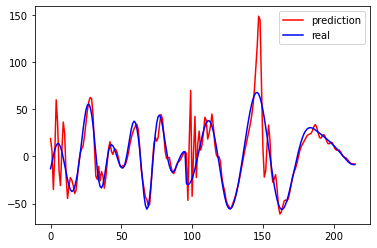

295.281854200585


In [54]:
net.load_state_dict(torch.load('example_wp_log.net_params.pkl')) 
var_data = torch.from_numpy(test_X)#.cuda()#net在GPU上面，所以输入的测试集合也要转入到GPU上面
pred_test = net(var_data) # 测试集的预测结果
pred_test = pred_test.cpu().view(-1).data.numpy()#先转移到cpu上才能转换为numpy

#乘以原来归一化的刻度放缩回到原来的值域 
origin_test_Y = test_Y*scalar
origin_pred_test = pred_test*scalar

#画图
plt.plot(origin_pred_test, 'r', label='prediction')
plt.plot(origin_test_Y, 'b', label='real')
plt.legend(loc='best')
plt.show()

#计算MSE
#loss = criterion(out, var_y)？
true_data = origin_test_Y
true_data = np.array(true_data)
true_data = np.squeeze(true_data)  # 从二维变成一维
MSE = true_data - origin_pred_test
MSE = MSE*MSE
MSE_loss = sum(MSE)/len(MSE)
print(MSE_loss)